# Setup Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 open questions & notes: 
- filter out all data that got added beyond march 2020
- We sparse data with the sqkm transformation and add a variance of about 3%
- The definition of EV can be quite different. In our case we look at battery-powered electric cars as well as plug-in hybrid vehicles.

In [30]:
# --------------
# Import the Data
# --------------
import os
import pandas as pd
import numpy as np
import locale
from locale import atof
import math
import matplotlib.pyplot as plt
import seaborn as sns
!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 7.8 MB 58.6 MB/s 
     |████████████████████████████████| 16.6 MB 50.8 MB/s 


In [3]:
# March 2020
population_df = pd.read_csv('/content/drive/MyDrive/TU DS Challenge/final Milestone/data/population_density.csv', sep=',', encoding='latin-1', header=0)

# August 2022 
charger_df = pd.read_csv('/content/drive/MyDrive/TU DS Challenge/final Milestone/data/charger_locations.csv', sep=';', encoding='ISO-8859-1', header=10, skipinitialspace=True)

#Data Preprocessing

In [4]:
# remove unnecessary columns
charger_df = charger_df[['Breitengrad', 'Längengrad']]

# rename columns for readability
charger_df = charger_df.rename(columns={'Breitengrad': 'ch_latitude', 'Längengrad': 'ch_longitude'})
population_df = population_df.rename(columns={'Lat': 'pop_latitude', 'Lon': 'pop_longitude', 'Population': 'pop_density'})

In [5]:
# Fix wrong values
def preprocess_lat_long(data, column):

  data[column] = data[column].apply(lambda x: x.replace(',','.'))
  data[column] = data[column].apply(lambda x: x.replace(',','.'))

  return data[column]

preprocess_lat_long(charger_df, 'ch_latitude')
preprocess_lat_long(charger_df, 'ch_longitude')

def preprocess_rstrip(data, column): # remove very last dot in a value in 'Breitengrad' column

  data[column] = data[column].apply(lambda x: x.rstrip('.'))

preprocess_rstrip(charger_df, 'ch_latitude')

In [6]:
# Convert charge location data types to float 64
locale.setlocale(locale.LC_NUMERIC, '')
charger_df['ch_latitude'] = charger_df['ch_latitude'].apply(atof).astype(np.float64)
charger_df['ch_longitude'] = charger_df['ch_longitude'].apply(atof).astype(np.float64)

In [7]:
# check for null values
print(charger_df.isnull().sum())
print(population_df.isnull().sum())

ch_latitude     0
ch_longitude    0
dtype: int64
pop_latitude     0
pop_longitude    0
pop_density      0
dtype: int64


In [8]:
# Rough shape of germany (in latitude and longitude)
# north: 55.060673
# east: 15.041248
# south: 47.259456
# west: 5.857632
# ====
# Longitude: 47.259456 - 55.060673
# Latitude: 5.857632 - 15.041248
# ====
# print("latitude", 113, "sample_num", round_float(5.857632, 3))
# print("longitude", 40075 * (math.cos(math.radians(5.857632)) / 360), "sample_num", round_float(47.259456, 3)) # 110.73819622579707
# print("longitude", 40075 * (math.cos(math.radians(15.041248 )) / 360), "sample_num", round_float(55.259456, 3)) # 107.5055566430472

longitude_border_south = 47.259456
longitude_border_north = 55.060673
latitude_border_west = 5.857632
latitude_border_east = 15.041248
degree_to_km_latitude = 113 # 1 Degree equals 113 km => having 2 decimal places will enable us to calculate roughly 1 km accuracy
degree_to_km_longitude_min = 40075 * (math.cos(math.radians(5.857632)) / 360) # 110.73819622579707 => having 2 decimal places will be roughly 1 km accuracy
degree_to_km_longitude_max = 40075 * (math.cos(math.radians(15.041248 )) / 360) # 107.5055566430472 => having 2 decimal places will be roughly 1 km accuracy
# Due to the fact that the distance between the latitudes is not the same, we have to calculate the distance between the longitude lines for each latitude line or go with a accuracy variance of about 3%

# filter out all charger locations that are not in the area of interest
charger_df = charger_df[(charger_df['ch_latitude'] >= longitude_border_south) & (charger_df['ch_latitude'] <= longitude_border_north)]
charger_df = charger_df[(charger_df['ch_longitude'] >= latitude_border_west) & (charger_df['ch_longitude'] <= latitude_border_east)]

# filter out all population locations that are not in the area of interest
population_df = population_df[(population_df['pop_latitude'] >= longitude_border_south) & (population_df['pop_latitude'] <= longitude_border_north)]
population_df = population_df[(population_df['pop_longitude'] >= latitude_border_west) & (population_df['pop_longitude'] <= latitude_border_east)]


In [9]:
# round all latitude and longitude values to 2 decimal places This will result in roughly 1km²
charger_df['ch_latitude'] = charger_df['ch_latitude'].apply(lambda x: round(x, 2))
charger_df['ch_longitude'] = charger_df['ch_longitude'].apply(lambda x: round(x, 2))

population_df['pop_latitude'] = population_df['pop_latitude'].apply(lambda x: round(x, 2))
population_df['pop_longitude'] = population_df['pop_longitude'].apply(lambda x: round(x, 2))

# sum up all chargers in a ~1km² area
charger_df = charger_df.groupby(['ch_latitude', 'ch_longitude']).size().reset_index(name='ch_count_per_sqkm')

# sum up all population in a ~1km² area
population_df = population_df.groupby(['pop_latitude', 'pop_longitude'])['pop_density'].sum().reset_index(name='pop_count_per_sqkm')


# Amount of EV in 2020 based on https://www.statista.com/statistics/1166543/electric-passenger-cars-number-by-segment-germany/ => 569.382
total_EV = 569382

# get total recorded population
total_population = population_df['pop_count_per_sqkm'].sum() 
print(total_population)
ev_per_person = round(total_EV / total_population, 10) 
print(ev_per_person)

# Add EVs to population_df
population_df['ev_count_per_sqkm'] = population_df['pop_count_per_sqkm'].apply(lambda x: round(x * ev_per_person, 10))



80392210.0085602
0.0070825519


At this point we have two tables ready to use:

- charger_df with charger location & density
- population_df with population location, density, ev_density

In [10]:
charger_df.head()

,ch_latitude,ch_longitude,ch_count_per_sqkm
0,47.29,11.29,1
1,47.35,10.26,2
2,47.36,12.59,1
3,47.41,10.27,1
4,47.41,10.28,2


In [11]:
population_df.head()

,pop_latitude,pop_longitude,pop_count_per_sqkm,ev_count_per_sqkm
0,47.27,10.18,1.289519,0.009133
1,47.28,10.18,5.158077,0.036532
2,47.28,10.20,2.579038,0.018266
3,47.28,10.21,6.447596,0.045665
4,47.28,10.22,2.579038,0.018266


In [12]:
population_df[population_df['pop_latitude'] == 48.53]

,pop_latitude,pop_longitude,pop_count_per_sqkm,ev_count_per_sqkm
44922,48.53,7.82,4.880423,0.034566
44923,48.53,7.83,4.880423,0.034566
44924,48.53,7.85,502.046625,3.555771
44925,48.53,7.86,757.667434,5.366219
44926,48.53,7.88,1.838999,0.013025
...,...,...,...,...
45430,48.53,13.68,13.352716,0.094571
45431,48.53,13.71,66.763579,0.472857
45432,48.53,13.72,54.437995,0.385560
45433,48.53,13.73,261.918657,1.855052


In [13]:
df = pd.read_csv('/content/drive/MyDrive/TU DS Challenge/Ladesaeulenregister_CSV.csv', sep=';', encoding='ISO-8859-1', header=10, skipinitialspace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34722 entries, 0 to 34721
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Betreiber               34722 non-null  object
 1   Straße                  34722 non-null  object
 2   Hausnummer              34722 non-null  object
 3   Adresszusatz            4846 non-null   object
 4   Postleitzahl            34722 non-null  int64 
 5   Ort                     34722 non-null  object
 6   Bundesland              34722 non-null  object
 7   Kreis/kreisfreie Stadt  34722 non-null  object
 8   Breitengrad             34722 non-null  object
 9   Längengrad              34722 non-null  object
 10  Inbetriebnahmedatum     34722 non-null  object
 11  Anschlussleistung       34722 non-null  object
 12  Normalladeeinrichtung   34722 non-null  object
 13  Anzahl Ladepunkte       34722 non-null  int64 
 14  Steckertypen1           34722 non-null  object
 15  P1

In [14]:
def preprocess_lat_long(data, column):

  data[column] = data[column].apply(lambda x: x.replace(',','.'))
  data[column] = data[column].apply(lambda x: x.replace(',','.'))

  return data[column]

preprocess_lat_long(df, 'Breitengrad')
preprocess_lat_long(df, 'Längengrad')

def preprocess_rstrip(data, column): # remove very last dot in a value in 'Breitengrad' column

  data[column] = data[column].apply(lambda x: x.rstrip('.'))

preprocess_rstrip(df, 'Breitengrad')

# Converting normal charging & fast charging to 0 & 1 respectively
df['Normalladeeinrichtung'].replace(['Normalladeeinrichtung', 'Schnellladeeinrichtung'],
                        [0, 1], inplace=True)

# Set locale to work with german commas as decimal separator to convert strings to float
locale.setlocale(locale.LC_NUMERIC, '')

# Declare final dtypes we want to have
df_dtypes = {
    "Betreiber"                 : "string",
    "Straße"                    : "string",
    "Hausnummer"                : "string", # String, since we have stuff like 10c as well here
    "Adresszusatz"              : "string",
    "Postleitzahl"              : "uint32",
    "Ort"                       : "string",
    "Bundesland"                : "string",
    "Kreis/kreisfreie Stadt"    : "string",
    "Breitengrad"                  : "float32", 
    "Längengrad"                 : "float32", 
    "Inbetriebnahmedatum"       : "datetime64",
    "Anschlussleistung"         : "float32", 
    "Normalladeeinrichtung"     : "object", # Should be boolean? --> should be binary (0,1) int
    "Anzahl Ladepunkte"         : "uint32",
    "Steckertypen1"             : "string", # enum?
    "P1 [kW]"                   : "float32", 
    "Public Key1"               : "string", 
    "Steckertypen2"             : "string",
    "P2 [kW]"                   : "float32", 
    "Public Key2"               : "string", 
    "Steckertypen3"             : "string",
    "P3 [kW]"                   : "float32", 
    "Public Key3"               : "string", 
    "Steckertypen4"             : "string",
    "P4 [kW]"                   : "float32", 
    "Public Key4"               : "string", 
}


# Parse df types

def clean_dtypes(df, column_name, final_dtype):
    try:
        if final_dtype == "object":
            return df[column_name].astype(final_dtype)
        elif final_dtype == "uint32" or final_dtype == "uint64":
            return df[column_name].replace(np.nan, 0).astype(final_dtype)
        elif final_dtype == "float32" or final_dtype == "float64":
            return df[column_name].astype(str).apply(atof).astype(final_dtype)
        elif final_dtype == "string":
            return df[column_name].astype(final_dtype)
        elif final_dtype == "datetime64":
          return pd.to_datetime(df[column_name], format="%d.%m.%Y")
        return df[column_name].astype(final_dtype) # return the passed dtype without modification as a fallback
    except Exception as e:
        print("Error while converting column: " + column_name + " to dtype: " + final_dtype)
        print(e)
        return df[column_name]
    

def convert_dtypes(df, dtypes):
    for column, dtype in dtypes.items():
        df[column] = clean_dtypes(df, column, dtype)
    return df

converted_df = convert_dtypes(df, df_dtypes)
print(converted_df.dtypes)

Betreiber                         string
Straße                            string
Hausnummer                        string
Adresszusatz                      string
Postleitzahl                      uint32
Ort                               string
Bundesland                        string
Kreis/kreisfreie Stadt            string
Breitengrad                      float32
Längengrad                       float32
Inbetriebnahmedatum       datetime64[ns]
Anschlussleistung                float32
Normalladeeinrichtung             object
Anzahl Ladepunkte                 uint32
Steckertypen1                     string
P1 [kW]                          float32
Public Key1                       string
Steckertypen2                     string
P2 [kW]                          float32
Public Key2                       string
Steckertypen3                     string
P3 [kW]                          float32
Public Key3                       string
Steckertypen4                     string
P4 [kW]         

In [15]:
df['Breitengrad'] = df['Breitengrad'].apply(lambda x: round(x, 2))
df['Längengrad'] = df['Längengrad'].apply(lambda x: round(x, 2))

In [16]:
population_df.rename(columns = {'pop_latitude':'latitude', 'pop_longitude':'longitude'}, inplace = True)
charger_df.rename(columns = {'ch_latitude':'latitude', 'ch_longitude':'longitude'}, inplace = True)

In [17]:
tmp = population_df.merge(charger_df)

In [20]:
tmp.head()

,latitude,longitude,pop_count_per_sqkm,ev_count_per_sqkm,ch_count_per_sqkm
0,47.35,10.26,95.424424,0.675848,2
1,47.41,10.27,857.530294,6.073503,1
2,47.41,10.28,1232.780392,8.731231,2
3,47.43,10.27,118.488271,0.839199,1
4,47.43,11.26,577.083319,4.087223,1


In [21]:
len(tmp)

16030

In [22]:
df.rename(columns = {'Breitengrad':'latitude', 'Längengrad':'longitude'}, inplace = True)

In [24]:
main = df.merge(tmp)

In [25]:
len(main)

34563

In [26]:
# --------------
# Milestone 3 - Add proper types
# --------------


#def preprocess_lat_long(data, column):

#  data[column] = data[column].apply(lambda x: x.replace(',','.'))
#  data[column] = data[column].apply(lambda x: x.replace(',','.'))

#  return data[column]

#preprocess_lat_long(df, 'Breitengrad')
#preprocess_lat_long(df, 'Längengrad')

#def preprocess_rstrip(data, column): # remove very last dot in a value in 'Breitengrad' column

#  data[column] = data[column].apply(lambda x: x.rstrip('.'))

#preprocess_rstrip(df, 'Breitengrad')

# Converting normal charging & fast charging to 0 & 1 respectively
try_lang['Normalladeeinrichtung'].replace(['Normalladeeinrichtung', 'Schnellladeeinrichtung'],
                        [0, 1], inplace=True)

# Set locale to work with german commas as decimal separator to convert strings to float
locale.setlocale(locale.LC_NUMERIC, '')

# Declare final dtypes we want to have
df_dtypes = {
    "Betreiber"                 : "string",
    "Straße"                    : "string",
    "Hausnummer"                : "string", # String, since we have stuff like 10c as well here
    "Adresszusatz"              : "string",
    "Postleitzahl"              : "uint32",
    "Ort"                       : "string",
    "Bundesland"                : "string",
    "Kreis/kreisfreie Stadt"    : "string",
    "latitude"                  : "float32", 
    "longitude"                 : "float32", 
    "Inbetriebnahmedatum"       : "datetime64",
    "Anschlussleistung"         : "float32", 
    "Normalladeeinrichtung"     : "object", # Should be boolean? --> should be binary (0,1) int
    "Anzahl Ladepunkte"         : "uint32",
    "Steckertypen1"             : "string", # enum?
    "P1 [kW]"                   : "float32", 
    "Public Key1"               : "string", 
    "Steckertypen2"             : "string",
    "P2 [kW]"                   : "float32", 
    "Public Key2"               : "string", 
    "Steckertypen3"             : "string",
    "P3 [kW]"                   : "float32", 
    "Public Key3"               : "string", 
    "Steckertypen4"             : "string",
    "P4 [kW]"                   : "float32", 
    "Public Key4"               : "string", 
}


# Parse df types

def clean_dtypes(df, column_name, final_dtype):
    try:
        if final_dtype == "object":
            return df[column_name].astype(final_dtype)
        elif final_dtype == "uint32" or final_dtype == "uint64":
            return df[column_name].replace(np.nan, 0).astype(final_dtype)
        elif final_dtype == "float32" or final_dtype == "float64":
            return df[column_name].astype(str).apply(atof).astype(final_dtype)
        elif final_dtype == "string":
            return df[column_name].astype(final_dtype)
        elif final_dtype == "datetime64":
          return pd.to_datetime(df[column_name], format="%d.%m.%Y")
        return df[column_name].astype(final_dtype) # return the passed dtype without modification as a fallback
    except Exception as e:
        print("Error while converting column: " + column_name + " to dtype: " + final_dtype)
        print(e)
        return df[column_name]
    

def convert_dtypes(df, dtypes):
    for column, dtype in dtypes.items():
        df[column] = clean_dtypes(df, column, dtype)
    return df

converted_df = convert_dtypes(try_lang, df_dtypes)
print(converted_df.dtypes)

Betreiber                         string
Straße                            string
Hausnummer                        string
Adresszusatz                      string
Postleitzahl                      uint32
Ort                               string
Bundesland                        string
Kreis/kreisfreie Stadt            string
latitude                         float32
longitude                        float32
Inbetriebnahmedatum       datetime64[ns]
Anschlussleistung                float32
Normalladeeinrichtung             object
Anzahl Ladepunkte                 uint32
Steckertypen1                     string
P1 [kW]                          float32
Public Key1                       string
Steckertypen2                     string
P2 [kW]                          float32
Public Key2                       string
Steckertypen3                     string
P3 [kW]                          float32
Public Key3                       string
Steckertypen4                     string
P4 [kW]         

In [27]:
len(main)

34563

#Exploratory Data Analysis

In [28]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34563 entries, 0 to 34562
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Betreiber               34563 non-null  string        
 1   Straße                  34563 non-null  string        
 2   Hausnummer              34563 non-null  string        
 3   Adresszusatz            4828 non-null   string        
 4   Postleitzahl            34563 non-null  uint32        
 5   Ort                     34563 non-null  string        
 6   Bundesland              34563 non-null  string        
 7   Kreis/kreisfreie Stadt  34563 non-null  string        
 8   latitude                34563 non-null  float64       
 9   longitude               34563 non-null  float64       
 10  Inbetriebnahmedatum     34563 non-null  datetime64[ns]
 11  Anschlussleistung       34563 non-null  float32       
 12  Normalladeeinrichtung   34563 non-null  object

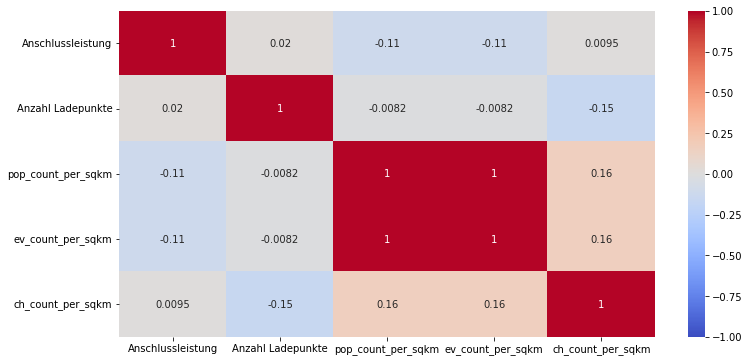

In [31]:
# Find correlation among selected continuous features

cols = ['Anschlussleistung', 'Anzahl Ladepunkte', 'pop_count_per_sqkm', 'ev_count_per_sqkm', 'ch_count_per_sqkm']

plt.figure(figsize=(12,6))
sns.heatmap(main[cols].corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [32]:
from osgeo import gdal
from shapely.geometry import Point, Polygon
plt.style.use('seaborn')

crs = {'init': 'epsg:4326'}

# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

map_df = gpd.read_file('plz-5stellig.shp', dtype={'plz': str})

map_df.head()

,plz,note,qkm,einwohner,geometry
0,01067,01067 Dresden,6.866862,11957,"POLYGON ((13.68689 51.06395, 13.69570 51.06499..."
1,01069,01069 Dresden,5.351833,25491,"MULTIPOLYGON (((13.72009 51.04664, 13.72248 51..."
2,01097,01097 Dresden,3.297752,14821,"POLYGON ((13.72548 51.06860, 13.72629 51.06900..."
3,01099,01099 Dresden,58.506789,28018,"POLYGON ((13.74218 51.08979, 13.74335 51.08863..."
4,01108,01108 Dresden,16.447222,5876,"POLYGON ((13.76543 51.17491, 13.76637 51.17469..."


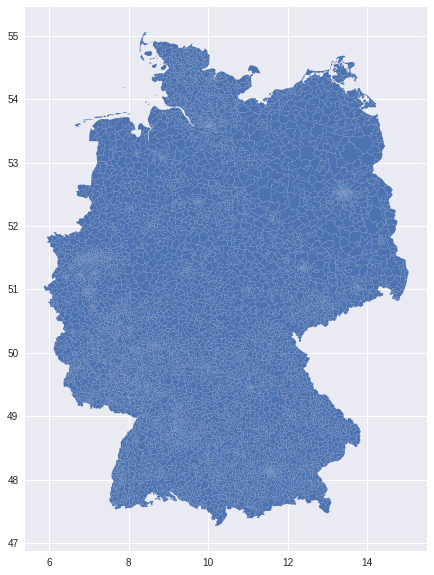

In [33]:
fig, ax = plt.subplots(figsize = (10, 10))
map_df.plot(ax = ax)

In [34]:
geometry = [Point(xy) for xy in zip(main['longitude'], main['latitude'])]
geometry[:3]

In [35]:
geo_df = gpd.GeoDataFrame(main
                          , crs = crs # coordinate reference system
                          , geometry = geometry) # specify the geometry created)
geo_df.head()

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Betreiber,Straße,Hausnummer,Adresszusatz,Postleitzahl,Ort,Bundesland,Kreis/kreisfreie Stadt,latitude,longitude,...,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Public Key4,pop_count_per_sqkm,ev_count_per_sqkm,ch_count_per_sqkm,geometry
0,EnBW mobility+ AG und Co.KG,Hauptstraße,91c,<NA>,73340,Amstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.58,9.87,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,681.288824,4.825263,1,POINT (9.87000 48.58000)
1,SWU Energie GmbH,Lindenstraße,7,<NA>,89176,Asselfingen,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.53,10.19,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,451.272166,3.196159,1,POINT (10.19000 48.53000)
2,SWU Energie GmbH,Öllengasse,10,<NA>,89177,Ballendorf,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.55,10.08,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,259.789534,1.839973,1,POINT (10.08000 48.55000)
3,SWU Energie GmbH,Sterngasse,6,<NA>,88481,Balzheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.18,10.08,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,724.317949,5.130019,1,POINT (10.08000 48.18000)
4,EnBW mobility+ AG und Co.KG,Heuweg,12,<NA>,89179,Beimerstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.48,9.98,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,906.557255,6.420739,1,POINT (9.98000 48.48000)


Text(0.5, 1.0, 'Power Distribution in Germany')

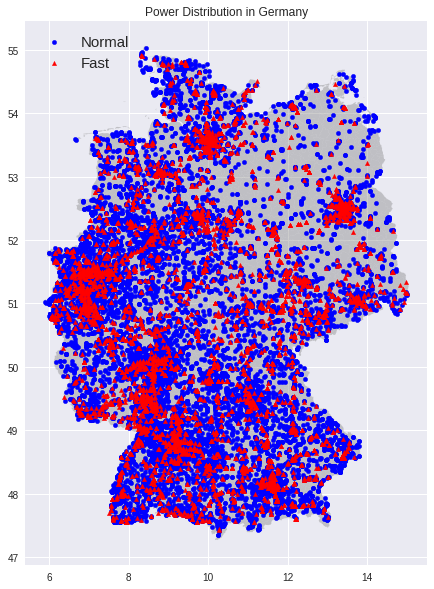

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
map_df.plot(ax = ax, alpha = 0.4, color='grey')
geo_df[geo_df['Normalladeeinrichtung'] == 0].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Normal')
geo_df[geo_df['Normalladeeinrichtung'] == 1].plot(ax = ax, markersize = 20, color = 'red', marker = '^', label = 'Fast')
plt.legend(prop={'size': 15})
plt.title('Power Distribution in Germany')

In [63]:
main.head()

,Betreiber,Straße,Hausnummer,Adresszusatz,Postleitzahl,Ort,Bundesland,Kreis/kreisfreie Stadt,latitude,longitude,...,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Public Key4,pop_count_per_sqkm,ev_count_per_sqkm,ch_count_per_sqkm,geometry
0,EnBW mobility+ AG und Co.KG,Hauptstraße,91c,<NA>,73340,Amstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.58,9.87,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,681.288824,4.825263,1,POINT (9.87000 48.58000)
1,SWU Energie GmbH,Lindenstraße,7,<NA>,89176,Asselfingen,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.53,10.19,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,451.272166,3.196159,1,POINT (10.19000 48.53000)
2,SWU Energie GmbH,Öllengasse,10,<NA>,89177,Ballendorf,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.55,10.08,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,259.789534,1.839973,1,POINT (10.08000 48.55000)
3,SWU Energie GmbH,Sterngasse,6,<NA>,88481,Balzheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.18,10.08,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,724.317949,5.130019,1,POINT (10.08000 48.18000)
4,EnBW mobility+ AG und Co.KG,Heuweg,12,<NA>,89179,Beimerstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.48,9.98,...,<NA>,NaN,<NA>,<NA>,NaN,<NA>,906.557255,6.420739,1,POINT (9.98000 48.48000)


In [101]:
#columns = ['Anschlussleistung', 'Anzahl Ladepunkte', 'Normalladeeinrichtung', 'Steckertypen1', 'P1 [kW]']
#columns = ['latitude', 'longitude', 'pop_count_per_sqkm', 'ev_count_per_sqkm', 'ch_count_per_sqkm', 'Anschlussleistung', 'Anzahl Ladepunkte', 'Normalladeeinrichtung']
columns = ['longitude', 'latitude', 'pop_count_per_sqkm', 'ev_count_per_sqkm', 'ch_count_per_sqkm', 'Anschlussleistung', 'Anzahl Ladepunkte', 'Normalladeeinrichtung']
#columns = ['latitude', 'longitude']

In [102]:
X = main[columns]
X.head()

,longitude,latitude,pop_count_per_sqkm,ev_count_per_sqkm,ch_count_per_sqkm,Anschlussleistung,Anzahl Ladepunkte,Normalladeeinrichtung
0,9.87,48.58,681.288824,4.825263,1,98.0,2,1
1,10.19,48.53,451.272166,3.196159,1,44.0,1,0
2,10.08,48.55,259.789534,1.839973,1,44.0,1,0
3,10.08,48.18,724.317949,5.130019,1,22.0,1,0
4,9.98,48.48,906.557255,6.420739,1,30.0,2,0


In [103]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34563 entries, 0 to 34562
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              34563 non-null  float64
 1   latitude               34563 non-null  float64
 2   pop_count_per_sqkm     34563 non-null  float64
 3   ev_count_per_sqkm      34563 non-null  float64
 4   ch_count_per_sqkm      34563 non-null  int64  
 5   Anschlussleistung      34563 non-null  float32
 6   Anzahl Ladepunkte      34563 non-null  uint32 
 7   Normalladeeinrichtung  34563 non-null  object 
dtypes: float32(1), float64(4), int64(1), object(1), uint32(1)
memory usage: 2.1+ MB


In [104]:
len(X)

34563

In [105]:
X.head()

,longitude,latitude,pop_count_per_sqkm,ev_count_per_sqkm,ch_count_per_sqkm,Anschlussleistung,Anzahl Ladepunkte,Normalladeeinrichtung
0,9.87,48.58,681.288824,4.825263,1,98.0,2,1
1,10.19,48.53,451.272166,3.196159,1,44.0,1,0
2,10.08,48.55,259.789534,1.839973,1,44.0,1,0
3,10.08,48.18,724.317949,5.130019,1,22.0,1,0
4,9.98,48.48,906.557255,6.420739,1,30.0,2,0


In [106]:
#columns = ['enc_long_lat', 'pop_count_per_sqkm', 'ev_count_per_sqkm', 'ch_count_per_sqkm', 'Anschlussleistung', 'Anzahl Ladepunkte', 'Normalladeeinrichtung']
columns = ['longitude', 'latitude', 'pop_count_per_sqkm', 'ch_count_per_sqkm', 'Anschlussleistung', 'Anzahl Ladepunkte', 'Normalladeeinrichtung']

X['Normalladeeinrichtung'] = X['Normalladeeinrichtung'].astype(float)

<ipython-input-106-d771a14fff4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Normalladeeinrichtung'] = X['Normalladeeinrichtung'].astype(float)


#Model Development

In [111]:
# Use the k-means algorithm to cluster the data into 10000 groups.
kmeans = KMeans(n_clusters=5000).fit(X)

# Get the center of each cluster.
cluster_centers = kmeans.cluster_centers_

# Print the centers of the clusters.
print(cluster_centers)

[[ 9.99428571e+00  4.99400000e+01  2.20701595e+03 ...  3.07142857e+01
   2.00000000e+00  0.00000000e+00]
 [ 1.05300000e+01  5.23000000e+01  6.05420174e+02 ...  2.64000000e+02
   2.00000000e+00 -5.55111512e-17]
 [ 1.12983333e+01  5.25033333e+01  4.55188208e+03 ...  4.40000000e+01
   2.00000000e+00  2.77555756e-17]
 ...
 [ 1.34200000e+01  5.25600000e+01  7.11569200e+03 ...  2.20000000e+01
   2.00000000e+00  0.00000000e+00]
 [ 8.20000000e+00  4.96900000e+01  1.68514928e+03 ...  1.10000000e+01
   1.00000000e+00  0.00000000e+00]
 [ 1.05200000e+01  5.22900000e+01  2.49517100e+03 ...  7.20000000e+01
   2.00000000e+00  1.00000000e+00]]


In [112]:
geometry = [Point(xy) for xy in cluster_centers]

# create a geopandas dataframe from the cluster centers
cluster_centers_gdf = gpd.GeoDataFrame(cluster_centers, geometry=geometry, crs="EPSG:31467")

In [113]:
cluster_centers_gdf

,0,1,2,3,4,5,6,7,geometry
0,9.994286,49.940000,2207.015952,15.631305,1.142857,30.714286,2.000000,0.000000e+00,POINT (9.994 49.940)
1,10.530000,52.300000,605.420174,4.287920,31.000000,264.000000,2.000000,-5.551115e-17,POINT (10.530 52.300)
2,11.298333,52.503333,4551.882081,32.238941,3.833333,44.000000,2.000000,2.775558e-17,POINT (11.298 52.503)
3,13.380000,52.510000,6464.255410,45.783424,25.000000,22.000000,1.111111,2.775558e-17,POINT (13.380 52.510)
4,7.466667,51.510000,3098.638466,21.946268,9.333333,11.000000,1.000000,2.775558e-17,POINT (7.467 51.510)
...,...,...,...,...,...,...,...,...,...
4995,8.090000,53.200000,401.461230,2.843370,1.714286,50.000000,2.000000,1.428571e-01,POINT (8.090 53.200)
4996,9.197857,49.057857,448.919935,3.179499,1.071429,43.428571,1.928571,2.775558e-17,POINT (9.198 49.058)
4997,13.420000,52.560000,7115.692002,50.397258,2.000000,22.000000,2.000000,0.000000e+00,POINT (13.420 52.560)
4998,8.200000,49.690000,1685.149283,11.935157,3.000000,11.000000,1.000000,0.000000e+00,POINT (8.200 49.690)


Text(0.5, 1.0, '5000 Recommended EV Charging Station Locations in Germany')

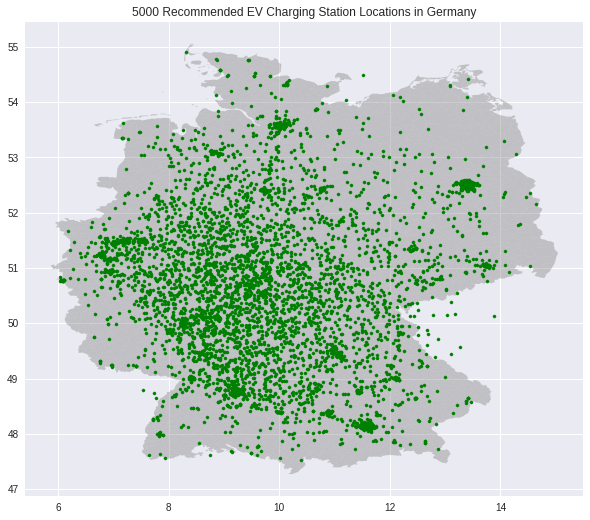

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
map_df.plot(ax = ax, alpha = 0.4, color='grey')
cluster_centers_gdf.plot(ax=ax, color="green", markersize=10)
plt.legend(prop={'size': 15})
plt.title('5000 Recommended EV Charging Station Locations in Germany')

#Model Evaluation

In [115]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, kmeans.labels_)

# Print the silhouette coefficient.
print("Silhouette coefficient: %.3f" % score)

Silhouette coefficient: 0.515


The Silhouette Coefficient is a measure of how well a data point is assigned to a cluster, with a score of 1 indicating a very good assignment and a score of -1 indicating a very poor assignment. Therefore, a Silhouette Coefficient of 0.515 would be considered to be a relatively good score, indicating that the data points are generally well-assigned to their clusters. However, without knowing the specific context in which the Silhouette Coefficient was calculated, it's difficult to say for sure whether 0.515 is a good score or not. In general, a Silhouette Coefficient of 0.5 or higher is considered to be a good score, but this can vary depending on the specific application.

In [116]:
# Compute the Calinski-Harabasz index for the clustering results.
from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(X, kmeans.labels_)

# Print the Calinski-Harabasz index.
print("Calinski-Harabasz index: %.3f" % score)

Calinski-Harabasz index: 1447683.785


The Calinski-Harabasz index is a measure of the quality of a clustering, with higher values indicating a better clustering. It is calculated based on the distances between the data points within a cluster and the distances between the clusters themselves. Therefore, a high Calinski-Harabasz index indicates that the clusters are well-separated and distinct from each other. In general, a Calinski-Harabasz index of 1454334.822 would be considered to be a very high value, indicating a very good clustering. However, without knowing the specific context in which the index was calculated, it's difficult to say for sure whether this is a good score or not. In general, a Calinski-Harabasz index of around 10,000 or higher is considered to be a good score, but this can vary depending on the specific application.

In [117]:
# Compute the Dunn index for the clustering results.
from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(X, kmeans.labels_)

# Print the Dunn index.
print("Dunn index: %.3f" % score)

Dunn index: 0.591


The Dunn index is a measure of the quality of a clustering, with higher values indicating a better clustering. It is calculated based on the distances between the data points within a cluster and the distances between the clusters themselves. Therefore, a high Dunn index indicates that the clusters are well-separated and distinct from each other. In general, a Dunn index of 0.593 would be considered to be a relatively high value, indicating a good clustering. However, without knowing the specific context in which the index was calculated, it's difficult to say for sure whether this is a good score or not. In general, a Dunn index of around 0.5 or higher is considered to be a good score, but this can vary depending on the specific application.